In [1]:
import os
import time
import datetime

import pandas as pd
import seaborn as sns
import numpy as np
import random

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.nn.parallel import DataParallel
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler, SequentialSampler
torch.manual_seed(42)

from transformers import GPT2LMHeadModel,  GPT2Tokenizer, GPT2Config, GPT2LMHeadModel
from transformers import AdamW, get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup
from transformers import AutoTokenizer, T5Config, T5ForConditionalGeneration
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()
import nltk

In [2]:
path = 'model_save/cls-5tasks-bs150-bs8-lr5e6-epoch100'
tokenizer = AutoTokenizer.from_pretrained(path, bos_token='<s>', eos_token='</s>', pad_token='[PAD]', padding_side='right') 
configuration = T5Config.from_pretrained(path, output_hidden_states=False)
model = T5ForConditionalGeneration.from_pretrained(path, config=configuration)
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = model.to(device)
model.eval()

OSError: model_save/cls-5tasks-bs150-bs8-lr5e6-epoch100 is not a local folder and is not a valid model identifier listed on 'https://huggingface.co/models'
If this is a private repository, make sure to pass a token having permission to this repo either by logging in with `huggingface-cli login` or by passing `token=<your_token>`

In [7]:
val_dataset = pd.read_csv('/home/hkqiu/work/PolyGPT/polymer properties/reg-cls/test/prompt-target.csv')
val_dataset.head()

prompt  target
0  Predict the Tg of the following SMILES: *CC(C)...  119.85
1  Predict the Tg of the following SMILES: C(C(C)...  119.85
2  Predict the Tg of the following SMILES: CC(*)(...  119.85
3  Predict the Tg of the following SMILES: *C(C*)...  119.85
4  Predict the Tg of the following SMILES: *C(C#N...  119.85

In [12]:
# 自定义函数来提取数字部分
def extract_number(string):
    number = string.split("<s> ")[1].split("</s>")[0]
    try:
      number = float(number)
    except:
      number = number

    return number 

def get_prediction(prompt):
  generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
  sample_outputs = model.generate(
                                generated, 
                                #bos_token_id=random.randint(1,30000),
                                do_sample=False,   
                                top_k=100, 
                                max_length = 8,
                                top_p=0.99, 
                                num_return_sequences=1
                                )

  predict = extract_number(tokenizer.decode(sample_outputs[0], skip_special_tokens=False))

  return predict


prompt_list = val_dataset['prompt'].tolist()

import time
# 记录开始时间
start_time = time.time()

predict_list = [get_prediction(i) for i in prompt_list]

# 记录结束时间
end_time = time.time()
# 计算运行时间
execution_time = end_time - start_time
# 打印运行时间
print("脚本运行时间：", execution_time, "秒")

脚本运行时间： 1116.4629061222076 秒


In [13]:
df=pd.read_csv('/home/hkqiu/work/PolyGPT/polymer properties/reg-cls/test/prompt-target.csv')
df['T5_prediction'] = pd.DataFrame(predict_list)
df.head()
df.to_csv('/home/hkqiu/work/PolyGPT/polymer properties/reg-cls/test/prompt-target-pred.csv')

MAE: 15.142970521541951
RMSE: 31.829207787675642
R2 score: 0.9370515926170158


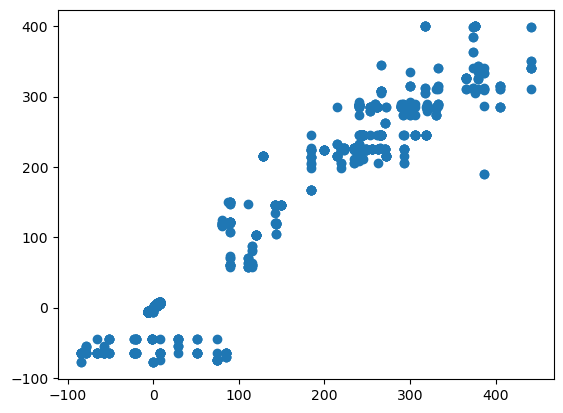

In [3]:
from sklearn.metrics import r2_score,mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# regression 

df = pd.read_csv('/home/hkqiu/work/PolyGPT/T5/0data&code/data/test/prompt-target-reg-pred.csv')

y_true = df['target'].tolist()
y_pred = df['T5_prediction'].tolist()

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)

print("MAE:", mae)
print("RMSE:", rmse)
print("R2 score:", r2)

plt.scatter(y_true, y_pred)
plt.show()


In [4]:
#Tg
tg_y_true = df['target'].tolist()[:700]
tg_y_pred = df['T5_prediction'].tolist()[:700]

#bandgap_crystal
bc_y_true = df['target'].tolist()[700:1179]
bc_y_pred = df['T5_prediction'].tolist()[700:1179]

#atomization energy
ae_y_true = df['target'].tolist()[1179:]
ae_y_pred = df['T5_prediction'].tolist()[1179:]

def evaluate_performance(property='tg'):
    y_true = eval(property + "_y_true")
    y_pred = eval(property + "_y_pred")

    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)

    print(f"{property}_MAE:", mae)
    print(f"{property}_RMSE:", rmse)
    print(f"{property}_R2 score:", r2)
    print("==============")


evaluate_performance('tg')
evaluate_performance('bc')
evaluate_performance('ae')

tg_MAE: 37.68134342857143
tg_RMSE: 50.522643213063525
tg_R2 score: 0.8523903746605785
bc_MAE: 0.587953235908142
bc_RMSE: 0.8201510599949596
bc_R2 score: 0.8477983351006754
ae_MAE: 0.09167521367521361
ae_RMSE: 0.11144658756705779
ae_R2 score: 0.8891584856684871


/tmp/ipykernel_29612/373739947.py:52: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax.plot([-300, 600], [-300, 600], 'k--', c='#329094', linewidth=1)
/tmp/ipykernel_29612/373739947.py:60: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax.plot([-7, -4.5], [-7, -4.5], 'k--', c='#329094', linewidth=1)
/tmp/ipykernel_29612/373739947.py:64: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax.plot([-300, 600], [-300, 600], 'k--', c='#329094', linewidth=1)


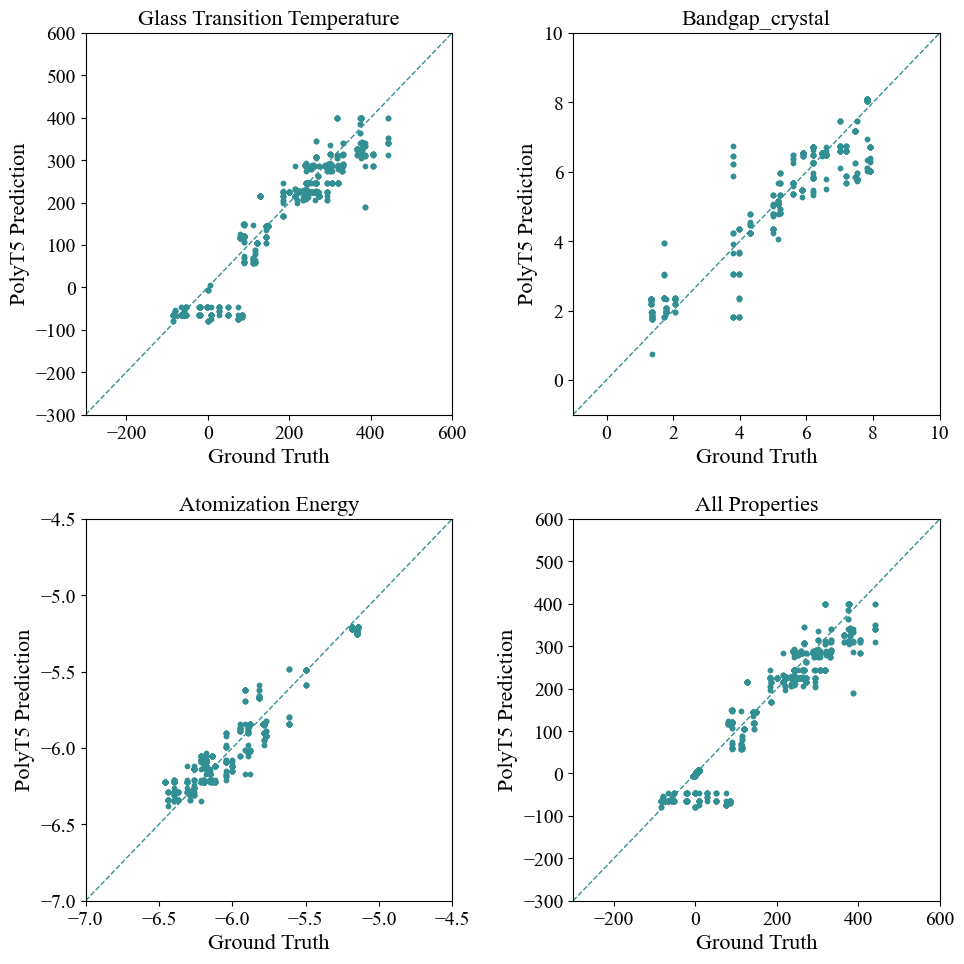

In [18]:
import matplotlib.font_manager as font_manager
import matplotlib.pyplot as plt

font_path = '/usr/share/fonts/Times/TIMES.TTF'  # Your font path goes here
font_manager.fontManager.addfont(font_path)
prop = font_manager.FontProperties(fname=font_path)
plt.rcParams['font.family'] = 'Times New Roman'

# 定义要绘制的图形数据
data = {
    'Glass Transition Temperature': {
        'x': tg_y_true,
        'y': tg_y_pred
    },
    'Bandgap_crystal': {
        'x': bc_y_true,
        'y': bc_y_pred
    },
    'Atomization Energy': {
        'x': ae_y_true,
        'y': ae_y_pred
    },
    'All Properties': {
        'x': y_true,
        'y': y_pred
    }
}

# 创建一个2x2的图形布局
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# 在每个子图中绘制散点图
for i, prefix in enumerate(['Glass Transition Temperature',
                            'Bandgap_crystal',
                            'Atomization Energy', 'All Properties']):
    x = data[prefix]['x']
    y = data[prefix]['y']
    ax = axs[i // 2, i % 2]  # 获取当前子图的坐标轴

    ax.scatter(x, y, c='#329094', s=10)
    ax.set_xlabel('Ground Truth', fontsize=16)
    ax.set_ylabel('PolyT5 Prediction', fontsize=16)
    ax.set_title(f'{prefix}', fontsize=16)

    # 设置字体大小
    ax.tick_params(axis='both', which='major', labelsize=14)

    # 根据子图设置y轴范围
    if prefix == 'Glass Transition Temperature':
        ax.set_xlim(-300, 600)
        ax.set_ylim(-300, 600)
        ax.plot([-300, 600], [-300, 600], 'k--', c='#329094', linewidth=1)
    elif prefix == 'Bandgap_crystal':
        ax.set_xlim(-1, 10)
        ax.set_ylim(-1, 10)
        ax.plot([-1, 10], [-1, 10], '--', c='#329094', linewidth=1)
    elif prefix == 'Atomization Energy':
        ax.set_xlim(-7, -4.5)
        ax.set_ylim(-7, -4.5)
        ax.plot([-7, -4.5], [-7, -4.5], 'k--', c='#329094', linewidth=1)
    if prefix == 'All Properties':
        ax.set_xlim(-300, 600)
        ax.set_ylim(-300, 600)
        ax.plot([-300, 600], [-300, 600], 'k--', c='#329094', linewidth=1)

# 调整子图之间的间距
plt.tight_layout(pad=2)

plt.savefig('./T5-fitting_scatter.png', dpi=1000)

# 显示图形
plt.show()

# cls

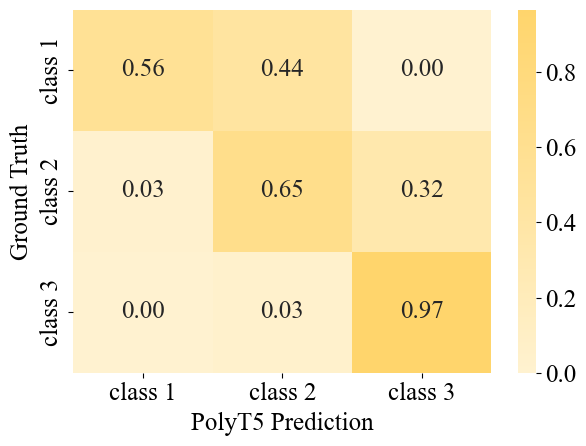

In [17]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import matplotlib.font_manager as font_manager
font_path = '/usr/share/fonts/Times/TIMES.TTF'  # Your font path goes here
font_manager.fontManager.addfont(font_path)
prop = font_manager.FontProperties(fname=font_path)
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 18
import matplotlib.pyplot as plt 
from matplotlib.colors import LinearSegmentedColormap


df = pd.read_csv('/home/hkqiu/work/PolyGPT/polymer properties/reg-cls/test/prompt-target-cls-pred.csv')

# 假设y_true是真实标签，y_pred是模型预测结果
y_true = df['target']
y_pred = df['T5_prediction']

# 创建标签列表
labels = ['class 1', 'class 2', 'class 3']

# 将字符标签转换为数字编码
label_mapping = {label: i for i, label in enumerate(labels)}
y_true = pd.Series(y_true).map(label_mapping)
y_pred = pd.Series(y_pred).map(label_mapping)

# 计算混淆矩阵
cm = confusion_matrix(y_true, y_pred)

# 计算每类的样本数
class_counts = df['target'].value_counts().sort_index()

# 将混淆矩阵中的每个单元格的值除以每类的样本数，得到比例
cm_normalized = cm / np.array(class_counts)[:, None]

colors = [
           '#FFF2D0', '#FFE39C', '#FFD56C']

cmap = LinearSegmentedColormap.from_list('custom_cmap', colors)

# 绘制混淆矩阵的热力图
sns.heatmap(cm_normalized, annot=True, fmt='.2f', xticklabels=labels, yticklabels=labels, cmap=cmap)
cbar = plt.colorbar(ax.collections[0], orientation='horizontal')

# 添加标题和坐标轴标签
plt.xlabel('PolyT5 Prediction')
plt.ylabel('Ground Truth')
plt.tight_layout()
plt.savefig('./CM.png', dpi=1000)
# 显示图形
plt.show()

/tmp/ipykernel_41155/4101295082.py:14: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(value_list)


Unnamed: 0       value
count   11.000000   11.000000
mean    61.000000  342.909091
std     26.713293   24.167973
min     25.000000  306.000000
25%     40.500000  329.500000
50%     57.000000  341.000000
75%     74.000000  364.000000
max    108.000000  379.000000

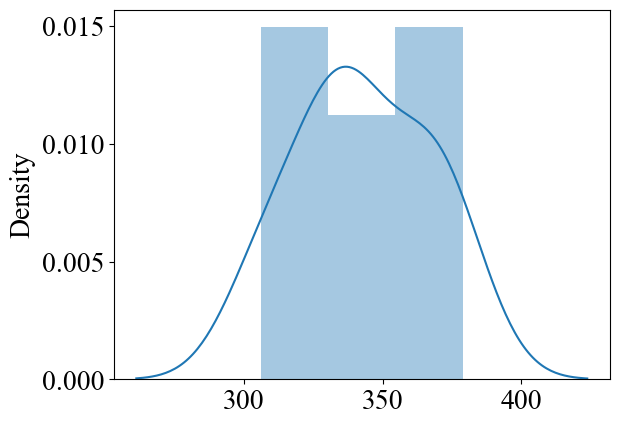

In [10]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns


file_path = '/home/hkqiu/work/PolyGPT/T5/data_code/data/test/polyimide_cls.csv'
df = pd.read_csv(file_path)

df_class2 = df[df['class'] == 'Class 2']
df_class2.describe()

value_list = df_class2['value'].tolist()

sns.distplot(value_list)
df_class2.describe()

In [2]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"T5 Neighbors Accuracy: {accuracy}")
print(f"T5 Neighbors Precision: {precision}")
print(f"T5 Neighbors Recall: {recall}")
print(f"T5 Neighbors F1 Score: {f1}")
print("=======================")

T5 Neighbors Accuracy: 0.8216216216216217
T5 Neighbors Precision: 0.8201206069312165
T5 Neighbors Recall: 0.8216216216216217
T5 Neighbors F1 Score: 0.8128517641448283


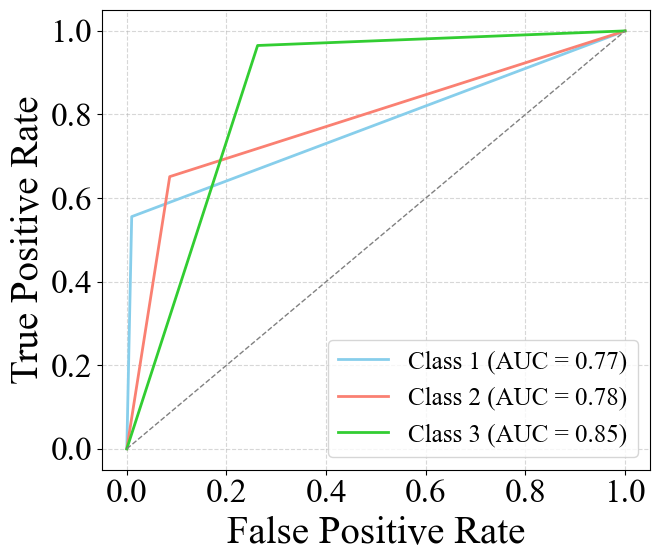

In [13]:
import pandas as pd
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# 读取数据
df = pd.read_csv('/home/hkqiu/work/PolyGPT/polymer properties/reg-cls/test/prompt-target-cls-pred.csv')

# 将字符标签转换为数值标签
label_mapping = {'class 1': 0, 'class 2': 1, 'class 3': 2}
y_true = df['target'].map(label_mapping)
y_pred = df['T5_prediction'].map(label_mapping)

# 计算三分类的ROC曲线和AUC
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve((y_true == i).astype(int), (y_pred == i).astype(int))
    roc_auc[i] = auc(fpr[i], tpr[i])

# 绘制ROC曲线
plt.figure(figsize=(7, 6))
colors = ['skyblue', 'salmon', 'limegreen']
labels = ['Class 1', 'Class 2', 'Class 3']
for i in range(3):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2, label='{} (AUC = {:.2f})'.format(labels[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.xlabel('False Positive Rate', fontsize=28)
plt.ylabel('True Positive Rate', fontsize=28)
plt.legend(loc='lower right', fontsize=18)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
# plt.savefig('./ROC.png', dpi=1000)
plt.show()